# <center><h2>Potato Leaf Disease Classification Using CNN </h2></center>

## Problem Statement :
Farmers every year face economic loss and crop waste due to various diseases in potato plants. Early blight and Late blight are major disease of potato leaf. It is estimated that the major loss occurred in potato yield is due to these diseases. Thus the images are classified into 3 classes :
1. Potato Late Blight, 
2. Potato Early Blight, 
3. Potato Healthy Leaf. 

The process involves several steps, including importing libraries, loading and viewing data, splitting the data into training and validation sets, data pre-processing, building the CNN model, training the model, and analyzing the model's performance.

**Step 1: Importing Libraries and Data** : In this step, we import the necessary libraries such as Pandas, NumPy, and TensorFlow. We also load the potato leaf images from the PlantVillage directory using tf.keras.preprocessing.image_dataset_from_directory. This function automatically loads the images from the directory and creates an image dataset along with their corresponding labels.

**Step 2: Viewing Data Images** : We visualize and inspect a few samples of the loaded data to ensure that the images are correctly loaded and to get an understanding of the dataset's structure.

**Step 3: Splitting the Data** : We split the dataset into training and validation sets. The training set is used to train the CNN model, while the validation set is used to evaluate the model's performance on unseen data.

**Step 4: Data Pre-processing** : Data pre-processing involves several steps to prepare the images for training. These steps include resizing and rescaling the images to a consistent size, data augmentation to increase the dataset's diversity and generalization, and other normalization techniques.

**Step 5: Model Building** : In this step, we build the CNN model using TensorFlow's Keras API. The model consists of Convolutional layers (Conv2D), MaxPooling layers to reduce the spatial dimensions, and other necessary layers. We optimize the model using the Adam optimizer and use Sparse Categorical Crossentropy as the loss function, as we have multiple classes and integer-encoded labels. We also define accuracy metrics to monitor the model's performance during training.

**Step 6: Model Training and Analysis** : We train the CNN model on the training set and evaluate its performance on the validation set. During training, we monitor metrics such as training accuracy, validation accuracy, training loss, and validation loss to analyze the model's behavior and identify potential overfitting.

**Step 7: Predicting on New Images (Unknown Leaf)** : Finally, we plot and analyze images from a new directory called "Unknown Leaf," which contains leaf images downloaded from the internet. We use the trained CNN model to predict the class (Potato Late Blight, Potato Early Blight, or Potato Healthy Leaf) of each unknown leaf image.

Dataset is available at Kaggle : https://www.kaggle.com/datasets/arjuntejaswi/plant-village

In [1]:
# importing libraries
import numpy as np # for linear algebra
import pandas as pd # data preprocessing

import tensorflow as tf # deep learning
from tensorflow.keras import layers, models # working on layers
import matplotlib.pyplot as plt # data visualization

## Step 1 : Importing Libraries and Data

In [2]:
# setting image_size and batch_size
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
# importing dataset directory 
df = tf.keras.preprocessing.image_dataset_from_directory("C:\\Users\\chaud\\Downloads\\PlantVillage",shuffle=True,image_size= (IMAGE_SIZE,IMAGE_SIZE),
                                                        batch_size= BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
# getting class names
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# len of dataset ( Total number of files/ batch size)
len(df)

68

In [6]:
68*32 #2176, but number of files are 2152 only

2176

In [7]:
print(df)  # None is the undefined batch size, (256,256) is the image size and 3 = channels(RGB)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Step 2 : Viewing Data Images

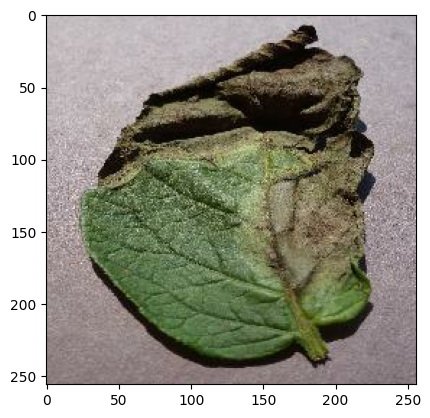

In [8]:
# viewing image 
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[4].numpy().astype("uint8"))
    
    # plt.axis("off") : used to view image without axis points
# refreshing every time gives another picture and label as given

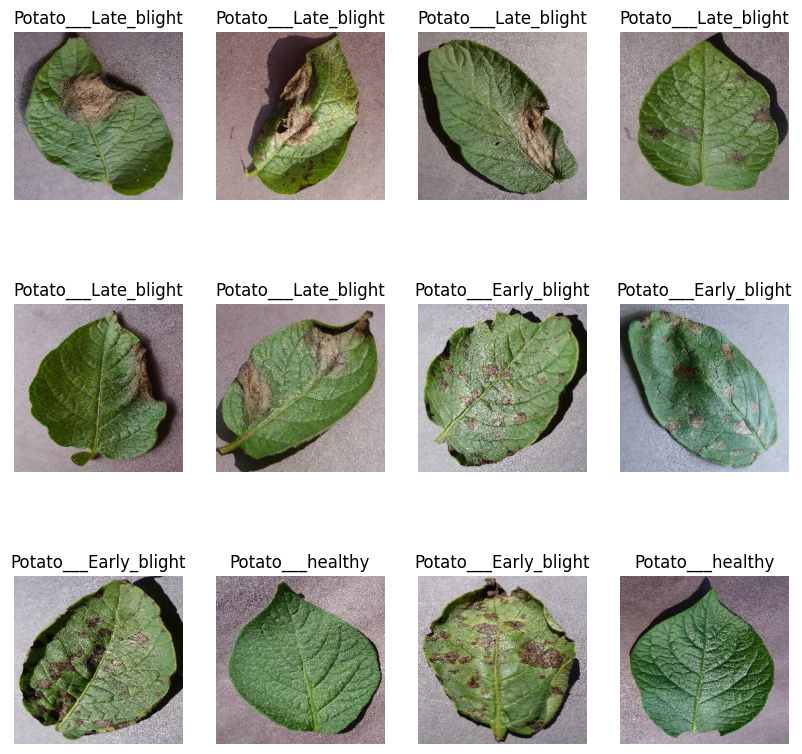

In [9]:
# images with the labels
plt.figure(figsize=(10,10))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        
# refreshing every time gives another picture and label as given

## Step 3 : Splitting Dataset

### 80% --> Training
### 20% --> 10% Validation and 10% Testing

In [72]:
# channels (RGB[Red, Green, Blue]), Epochs = 50
CHANNELS = 3
EPOCHS = 15

In [73]:
# checking the length of training data
train_size = 0.8
len(df) * train_size

54.400000000000006

In [76]:
# length of validation and test data
val_n_test = len(df) - (len(df) * train_size)
val_n_test

13.599999999999994

In [77]:
# splitting the data into training , validation and testing data

def split_datasets(pc,train_split = 0.8,val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        pc = pc.shuffle(shuffle_size,seed = 10)
        
    pc_size = len(pc) # size of potato_data(68)
    train_size = int(train_split*pc_size)
    val_size = int(val_split*pc_size)
    
    train_pc = pc.take(train_size) # taking first 54 batches(out of 68)
    val_pc = pc.skip(train_size).take(val_size) # leaving first 54 and taking next 6 batches
    test_pc = pc.skip(train_size).skip(val_size) # skipping first 54(train) batch and 6(validation) batch and 
                                                 #taking left 8 batches for test
    
    return train_pc, val_pc, test_pc

In [78]:
# getting the training, validation and testing data by 'split_datasets' function
train_data, val_data, test_data = split_datasets(df)

In [79]:
# printing the size of all data splits
print("Size of Data is :{0} \nBatch Size of Training Data is :{1} \nBatch Size of Validation Data :{2} \nBatch Size of Test Data :{3}"
      .format(len(df), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch Size of Training Data is :54 
Batch Size of Validation Data :6 
Batch Size of Test Data :8


In [80]:
# caching, shuffling and prefetching the data
train_pc = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_pc = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_pc = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

## Step 4 : Data Pre-Processing 

In [81]:
from tensorflow.keras import layers  # Import layers properly

# Image Preprocessing : Rescaling and Resizing
rescale_n_resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # No need for 'experimental'
    layers.Rescaling(1.0 / 255)
])

# Data Augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.2),  # instead of 0.5 for more natural variations
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(factor=0.1)
])


## Step 5 : Model Building

In [82]:
model = models.Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Input shape
    rescale_n_resize,
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # ⬇️ Replaces Flatten + saves memory
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes
])

In [83]:
# model_summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             3

 Total params: 423,619 (1.62 MB)

 Trainable params: 422,659 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [84]:
# optimizing the model
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

## Step 6 : Model Training and Analysis

In [ ]:
# fitting the model
history = model.fit(train_data, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose=1)

Epoch 1/15
 7/54 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - accuracy: 0.7618 - loss: 0.6914

In [67]:
scores = model.evaluate(train_data)
print(f"Training Loss: {scores[0]}")
print(f"Training Accuracy: {scores[1]}")


54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 928ms/step - accuracy: 0.5222 - loss: 2.1499
Training Loss: 1.9418058395385742
Training Accuracy: 0.5639671087265015


In [68]:
# getting the keys of fitted model "History"
print("Params:", history.params)
print("History Keys:", history.history.keys())


Params: {'verbose': 1, 'epochs': 10, 'steps': 54}
History Keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [69]:
# assigning names to the keys

train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

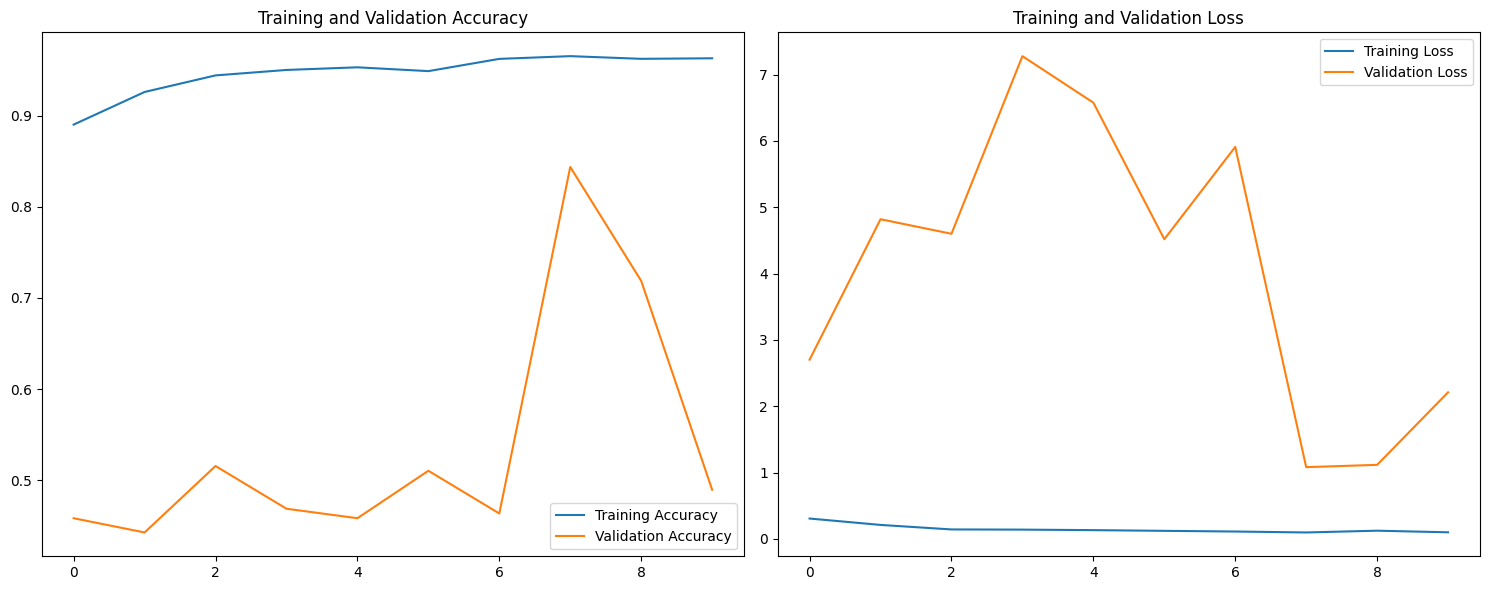

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), train_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), train_loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


## Validation on Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


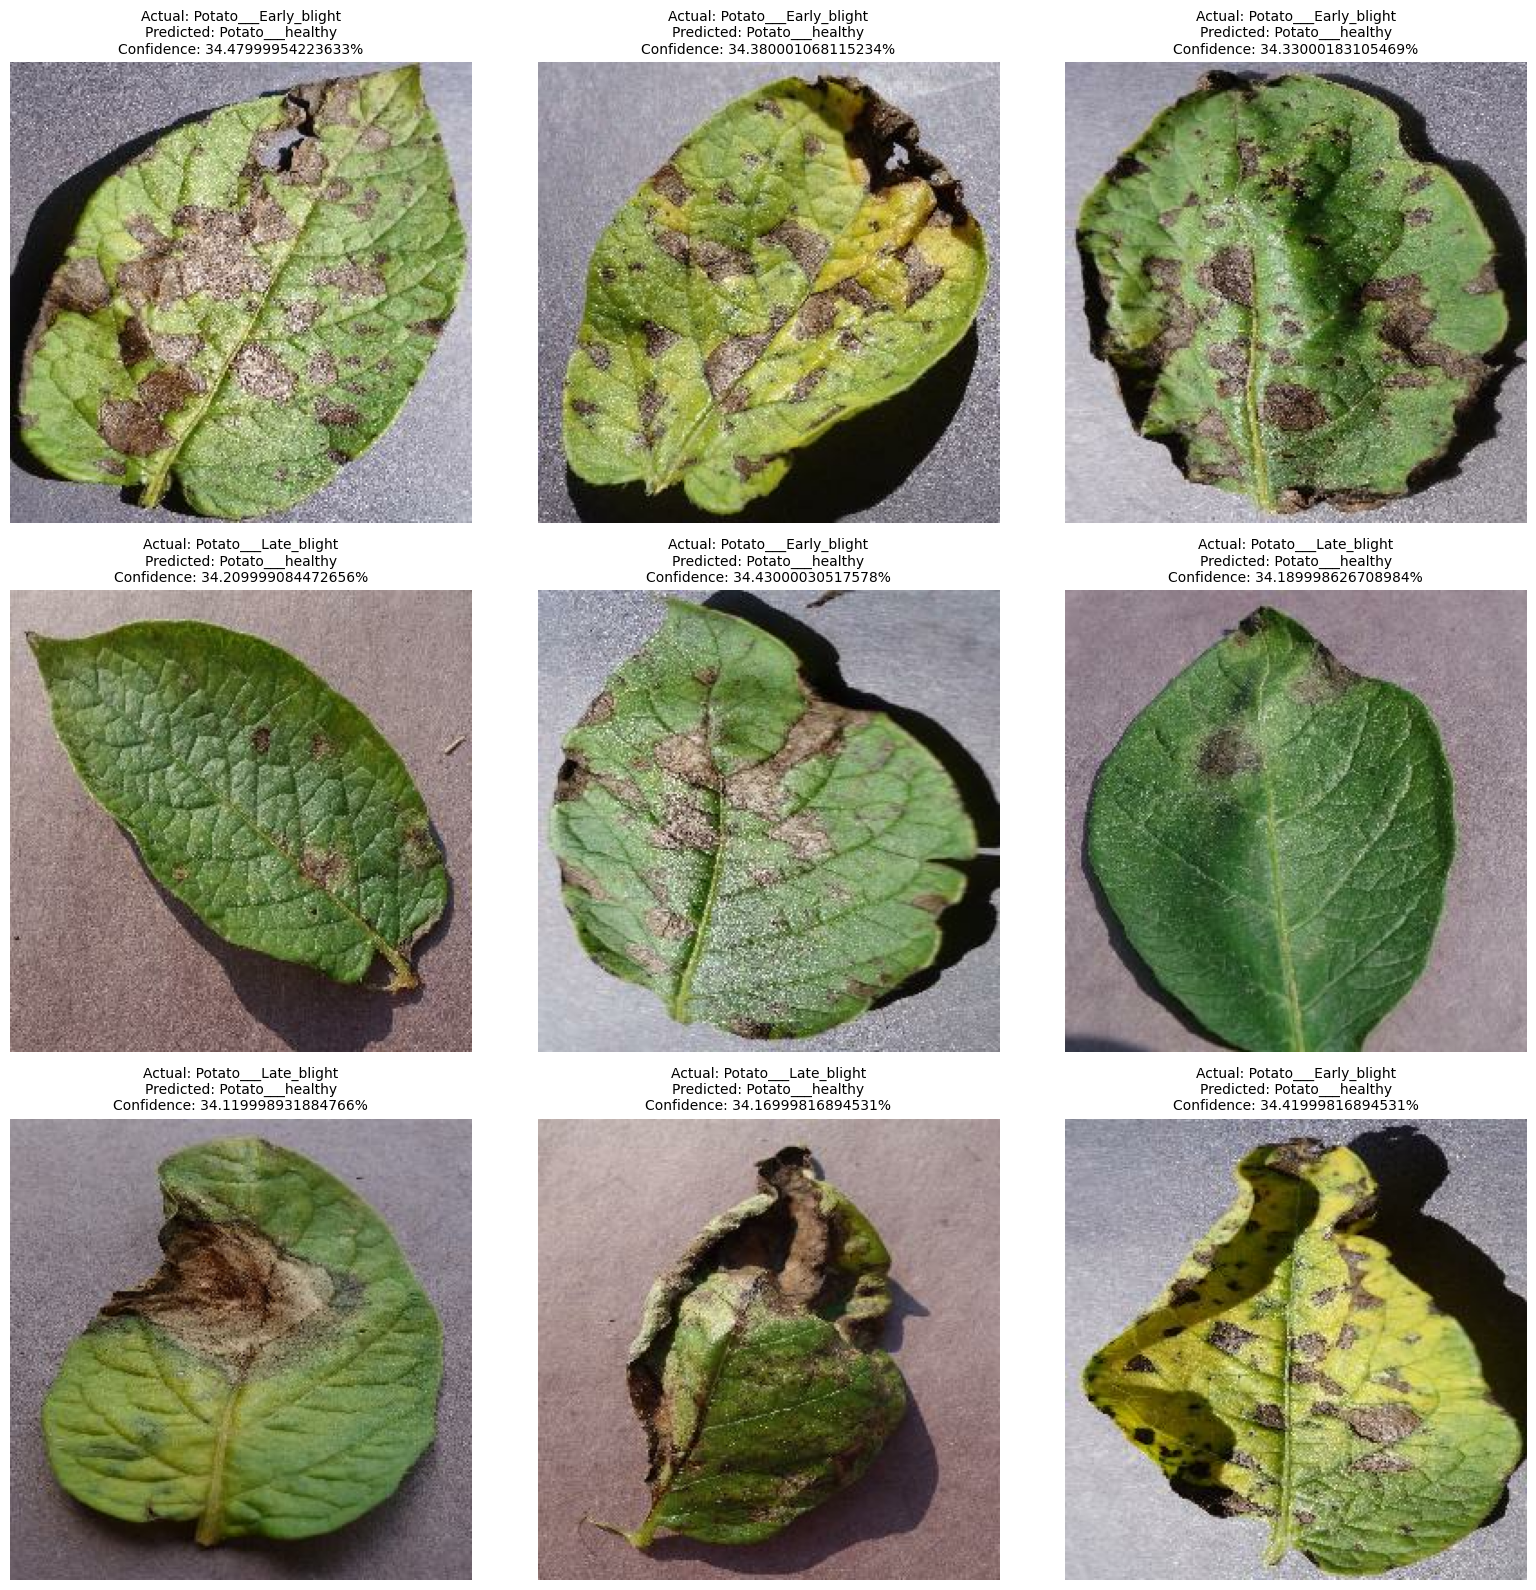

In [61]:
plt.figure(figsize=(16, 16))

# Take one batch from test data
for batch_image, batch_label in test_pc.take(1):
    num_images = batch_image.shape[0]
    num_to_plot = min(9, num_images)

    # Predict all images in the batch
    batch_prediction = model.predict(batch_image)

    for i in range(num_to_plot):
        ax = plt.subplot(3, 3, i + 1)
        image = batch_image[i].numpy().astype('uint8')
        actual_label = class_names[batch_label[i]]
        predicted_label = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)

        plt.imshow(image)
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%", fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🔍 Classification Report:

                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.19      0.32       105
 Potato___Late_blight       0.52      1.00      0.69       111
     Potato___healthy       0.00      0.00      0.00        16

             accuracy                           0.56       232
            macro avg       0.51      0.40      0.34       232
         weighted avg       0.70      0.56      0.47       232

✅ Accuracy: 56.47%



C:\Users\chaud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chaud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chaud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

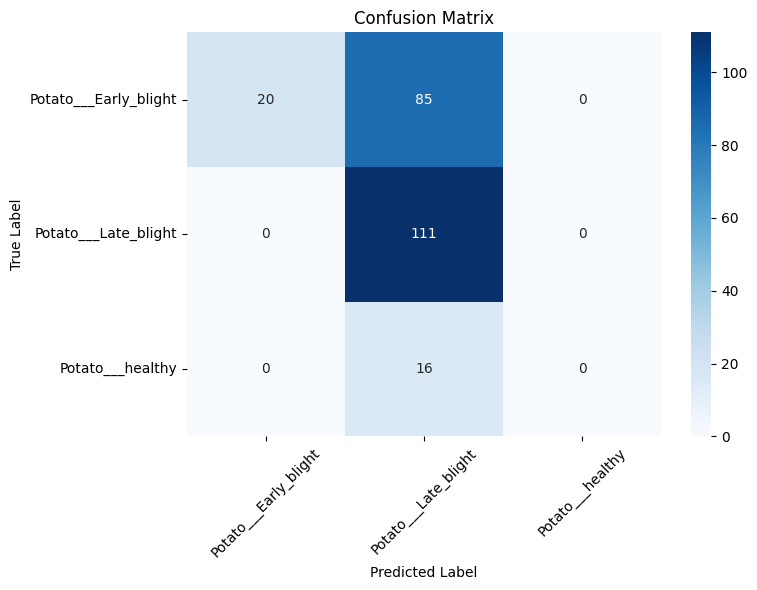

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure you have class names available
# Example:
# class_names = ["Healthy", "Early Blight", "Late Blight"]

# Step 1: Get true and predicted labels
true_labels = []
pred_labels = []

for images, labels in test_pc:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Step 2: Print classification report
print("🔍 Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Step 3: Print accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"✅ Accuracy: {accuracy * 100:.2f}%\n")

# Step 4: Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



## Step 7 : Predicting on New Images

In [41]:
import os
print(os.path.exists("C:\\Users\\chaud\\Downloads\\Potato_Unknown leafs"))


True


In [42]:
# importing new dataset for new predictions
unk_lf = tf.keras.preprocessing.image_dataset_from_directory("C:\\Users\\chaud\\Downloads\\Potato_Unknown leafs",image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 6 files belonging to 3 classes.


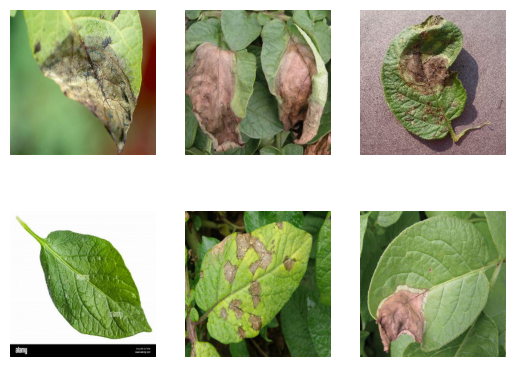

In [43]:
# viewing new images
for image_batch, label_batch in unk_lf.take(1):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


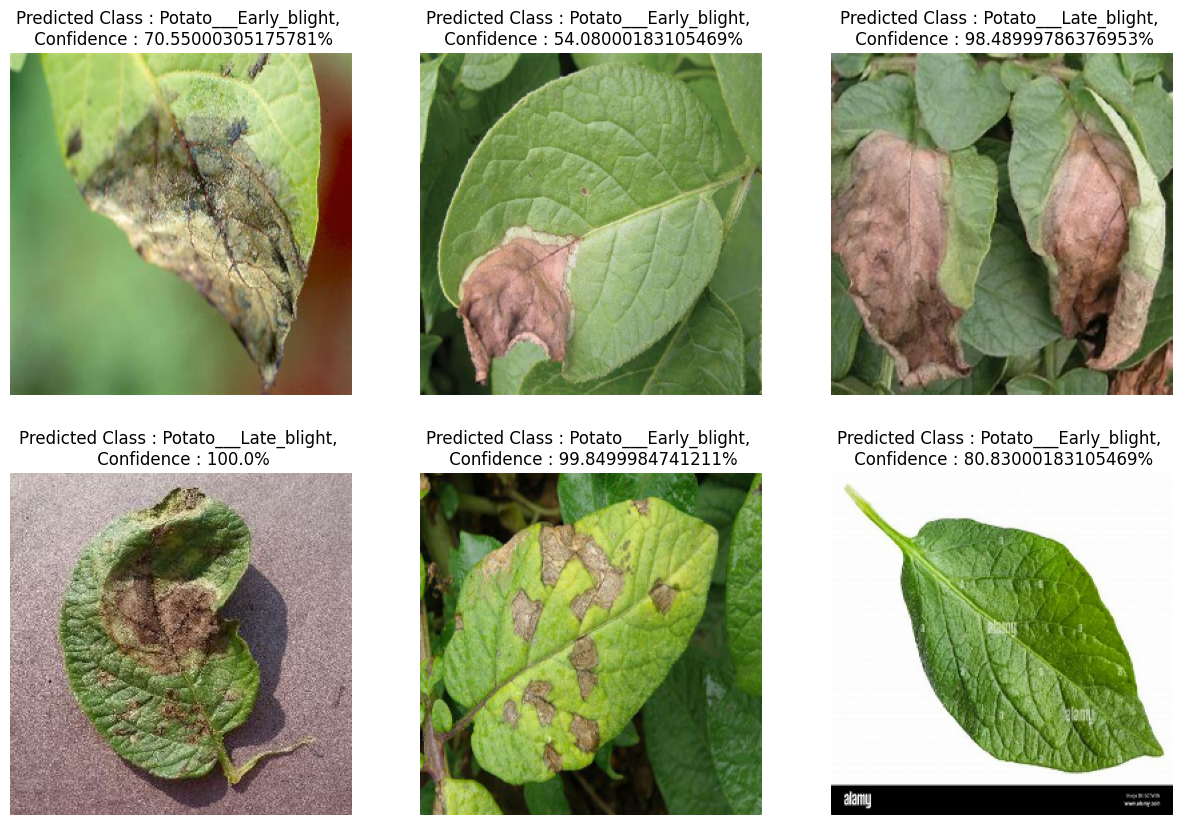

In [30]:
# predicting the class
plt.figure(figsize = (15,10))
for image_batch, label_batch in unk_lf.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        image = image_batch[i].numpy().astype("uint8")
        label = class_names[label_batch[i]]
        
        plt.imshow(image)

                
        unk_lf_pred = model.predict(image_batch)
        pred_class = class_names[np.argmax(unk_lf_pred[i])]
        confidence = round(np.max(unk_lf_pred[i])*100, 2)
        
        plt.title(f'Predicted Class : {pred_class}, \n Confidence : {confidence}%')
        
        plt.axis("off")

In [31]:
# Save the trained model in Keras format
model.save('potato_disease_model1.keras')
print('Model saved successfully as potato_disease_model1.keras')

Model saved successfully as potato_disease_model1.keras


In [32]:
import cv2

In [33]:
def prediction(image_path, class_names = df.class_names):

    # Read and Resize the Image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))

    # Read and Resize the Image using Pillow
    # img = Image.open(image_path).resize((image_size,image_size))

    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Converting Image to Array using TensorFlow
    img_array = np.expand_dims(img_array, axis=0)               # Expanding Image Array to Include Batch Dimension: (256, 256, 3) to (1, 256, 256, 3)

    model = tf.keras.models.load_model('/content/model.h5')     # Load the Trained TensorFlow Model
    prediction = model.predict(img_array)                       # Predict the Index of Class_Label

    predicted_class = class_names[np.argmax(prediction)]        # Find out the Class_Label_Name from Prediction_Dict (Using Max Probability Index)
    confidence = round(np.max(prediction)*100, 2)               # Calculate the Model Confidence

    print(f'Predicted Class : {predicted_class}')
    print(f'Confident : {confidence}%')
    print('')
    plt.imshow(img)
    plt.axis('off')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Predicted Class : Potato___Early_blight
Confident : 100.0%



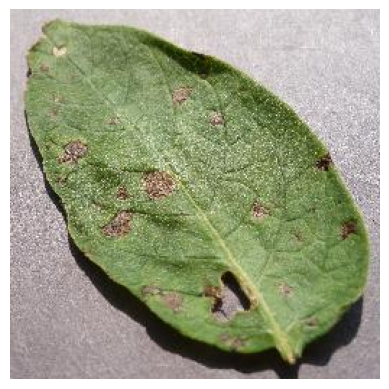

In [34]:
prediction(image_path = r"C:\Users\chaud\Downloads\PlantVillage\Potato___Early_blight\f7a5e3e3-796e-4f4a-943c-24d26e2591d4___RS_Early.B 8679.JPG")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Predicted Class : Potato___Late_blight
Confident : 99.83999633789062%



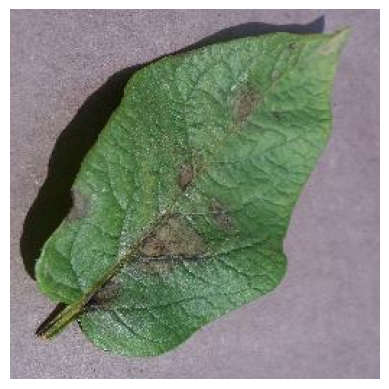

In [35]:
prediction(image_path =r"C:\Users\chaud\Downloads\PlantVillage\Potato___Late_blight\f46c0317-fc28-4b5b-a09d-b52ef54fae67___RS_LB 3889.JPG")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Predicted Class : Potato___healthy
Confident : 66.94999694824219%



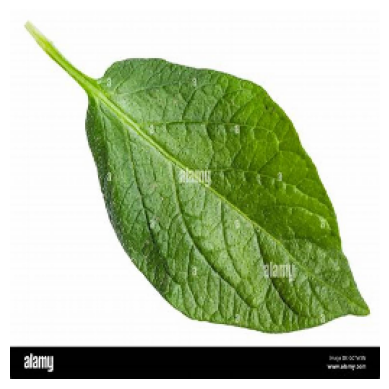

In [36]:
prediction(image_path = r"C:\Users\chaud\Downloads\Potato_Unknown leafs\class 1\5.jpg")

# <center><h1> Thank You! </h1></center>